In [1]:
# import 부분
import pandas as pd
import glob
import os


bill_df_with_segment = pd.read_csv("data/청구입금정보_with_segment.csv")

In [2]:
bill_df_with_segment

기준년월            ID  대표결제일 대표결제방법코드 대표청구지고객주소구분코드 대표청구서수령지구분코드  \
0        201807  TRAIN_000000     27     자동이체           미확인    당사페이앱+이메일   
1        201807  TRAIN_000001     13     자동이체           주거지           우편   
2        201807  TRAIN_000002      1     자동이체           미확인          이메일   
3        201807  TRAIN_000003      5     자동이체           주거지           우편   
4        201807  TRAIN_000004     13     자동이체           주거지           우편   
...         ...           ...    ...      ...           ...          ...   
2399995  201812  TRAIN_399995     25     자동이체           주거지           우편   
2399996  201812  TRAIN_399996     20     자동이체           미확인          이메일   
2399997  201812  TRAIN_399997     20     자동이체            회사           우편   
2399998  201812  TRAIN_399998     20     자동이체           주거지           우편   
2399999  201812  TRAIN_399999     23     자동이체           주거지           우편   

        청구서수령방법  청구서발송여부_B0  청구서발송여부_R3M  청구서발송여부_R6M  ...  상환개월수_결제일_R6M  \
0         문자메세지           1            1            1  ...              5   
1            우편           1            1            1  ...              6   
2           이메일           1            1            1  ...              6   
3            우편           1            1            1  ...              5   
4            우편           0            1            1  ...              1   
...         ...         ...          ...          ...  ...            ...   
2399995      우편           0            0            0  ...              0   
2399996     이메일           1            1            1  ...              6   
2399997      우편           1            1            1  ...              6   
2399998      우편           0            0            0  ...              0   
2399999      우편           1            1            1  ...              6   

         상환개월수_결제일_R3M  선결제건수_R6M  선결제건수_R3M  연체건수_R6M  연체건수_R3M  혜택수혜금액_R3M  \
0                    3          0          0         1         0           3   
1                    3          0          0         0         0           0   
2                    3          0          0         0         0         121   
3                    3          2          0         0         0           3   
4                    1          0          0         0         0           0   
...                ...        ...        ...       ...       ...         ...   
2399995              0          0          0         0         0           0   
2399996              3          0          0         0         0         164   
2399997              3          0          0         0         0           0   
2399998              0          0          0         0         0           0   
2399999              3          0          0         0         0           0   

         포인트_마일리지_환산_B0M  혜택수혜금액  Segment  
0                      0       0        D  
1                      0       0        E  
2                      0      50        C  
3                      0       2        D  
4                      0       0        E  
...                  ...     ...      ...  
2399995                0       0        E  
2399996                0      53        D  
2399997                0       0        C  
2399998                0       0        E  
2399999                0       0        E  

[2400000 rows x 47 columns]

### 할인 관련 변수 살펴보기

In [4]:
discount_columns = [col for col in bill_df_with_segment.columns if col.startswith('할인')]
print(discount_columns)

['할인건수_R3M', '할인금액_R3M', '할인건수_B0M', '할인금액_B0M', '할인금액_청구서_R3M', '할인금액_청구서_B0M']


In [5]:
bill_df_with_segment['할인건수_R3M'].value_counts()

할인건수_R3M
1회 이상     2142271
10회 이상     196651
20회 이상      53009
30회 이상       8065
40회 이상          4
Name: count, dtype: int64

In [6]:
discount_r3m = bill_df_with_segment.groupby("Segment")['할인건수_R3M'].value_counts().unstack().fillna(0)

# 원하는 순서 명시적 지정
desired_order = ["1회 이상", "10회 이상", "20회 이상", "30회 이상", "40회 이상"]

# discount_r3m 교차표에서 해당 열만 추출
discount_r3m_filtered = discount_r3m[desired_order]
display(discount_r3m_filtered)

할인건수_R3M      1회 이상    10회 이상   20회 이상  30회 이상  40회 이상
Segment                                               
A             861.0      99.0     12.0     0.0     0.0
B             114.0      25.0      5.0     0.0     0.0
C           92466.0   24225.0   8856.0  2042.0     1.0
D          256397.0   66435.0  22196.0  4211.0     3.0
E         1792433.0  105867.0  21940.0  1812.0     0.0

In [7]:
# 할인건수_R3M 비율표 생성
discount_r3m_ratio = bill_df_with_segment.groupby("Segment")['할인건수_R3M'].value_counts(normalize=True).unstack().fillna(0)

# 원하는 순서 명시적으로 지정
desired_order = ["1회 이상", "10회 이상", "20회 이상", "30회 이상", "40회 이상"]

# discount_r3m_ratio에서 해당 열만 추출
discount_r3m_ratio_filtered = discount_r3m_ratio[desired_order]

# 출력
from IPython.display import display
display(discount_r3m_ratio_filtered)

할인건수_R3M     1회 이상    10회 이상    20회 이상    30회 이상    40회 이상
Segment                                                   
A         0.885802  0.101852  0.012346  0.000000  0.000000
B         0.791667  0.173611  0.034722  0.000000  0.000000
C         0.724712  0.189866  0.069410  0.016004  0.000008
D         0.734153  0.190226  0.063555  0.012058  0.000009
E         0.932562  0.055080  0.011415  0.000943  0.000000

In [8]:
# 1. 가중치 지정
weights = {
    "1회 이상": 1,
    "10회 이상": 10,
    "20회 이상": 20,
    "30회 이상": 30,
    "40회 이상": 40
}

# 2. 가중치 곱해서 점수 계산
discount_score = discount_r3m_ratio_filtered.copy()
for col in discount_score.columns:
    discount_score[col] *= weights[col]

# 3. 세그먼트별 총 점수 계산
segment_discount_score = discount_score.sum(axis=1).sort_values(ascending=False)

# 4. 결과 출력
print("세그먼트별 가중 점수 합계 (높을수록 최근 3개월 내 할인건수 이용도가 높은 세그먼트)")
display(segment_discount_score)

세그먼트별 가중 점수 합계 (높을수록 최근 3개월 내 할인건수 이용도가 높은 세그먼트)


Segment
C    4.492013
D    4.269581
B    3.222222
A    2.151235
E    1.739944
dtype: float64

In [9]:
bill_df_with_segment['할인건수_B0M'].value_counts()

할인건수_B0M
1회 이상     2388828
10회 이상      11172
Name: count, dtype: int64

In [10]:
# 1. 할인건수_B0M이 '10회 이상'인 경우만 필터링
filtered_df = bill_df_with_segment[bill_df_with_segment['할인건수_B0M'] == '10회 이상']

# 2. 세그먼트별 도수 확인
segment_distribution = filtered_df['Segment'].value_counts().sort_values(ascending=False)

# 3. 세그먼트별 비율 확인
segment_ratio = filtered_df['Segment'].value_counts(normalize=True).sort_values(ascending=False)

# 결과 출력
from IPython.display import display
print("✅ 할인건수_B0M = '10회 이상' 조건일 때 세그먼트별 분포:")
display(segment_distribution)

print("\n📊 세그먼트별 비율:")
display(segment_ratio)

✅ 할인건수_B0M = '10회 이상' 조건일 때 세그먼트별 분포:


Segment
D    5603
E    2835
C    2732
A       2
Name: count, dtype: int64


📊 세그먼트별 비율:


Segment
D    0.501522
E    0.253759
C    0.244540
A    0.000179
Name: proportion, dtype: float64

In [11]:
# 1. 세그먼트별 할인금액 평균 계산
discount_avg = bill_df_with_segment.groupby("Segment")[["할인금액_R3M", "할인금액_B0M"]].mean()

# 2. 소수점 2자리로 반올림
discount_avg_rounded = discount_avg.round(2)

# 3. 결과 출력
from IPython.display import display
print("✅ 세그먼트별 할인금액 평균")
display(discount_avg_rounded)

✅ 세그먼트별 할인금액 평균


할인금액_R3M  할인금액_B0M
Segment                    
A           57.66     16.17
B          144.45     44.26
C          163.62     52.23
D          149.32     47.69
E           62.58     19.84

- C 세그먼트가 최근 3개월(R3M)과 현재월(B0M) 모두 가장 높은 할인금액 평균을 보임 → 우수 고객일 가능성 높음.
- A 세그먼트는 두 기간 모두 할인금액 평균이 가장 낮음 → 할인 유도에 덜 반응하는 고객군일 수 있음.
- E 세그먼트는 A보다는 조금 높지만, 여전히 상대적으로 낮은 편임.

In [13]:
bill_df_with_segment['할인금액_청구서_R3M'].value_counts()

할인금액_청구서_R3M
0       1532322
27        58491
150       42216
149       19634
26        18810
         ...   
1702          1
1698          1
1713          1
1716          1
1707          1
Name: count, Length: 1723, dtype: int64

In [14]:
bill_df_with_segment['할인금액_청구서_B0M'].value_counts()

할인금액_청구서_B0M
0      1680577
9        65703
50       48620
8        19043
49       18776
        ...   
645          1
657          1
688          1
580          1
595          1
Name: count, Length: 584, dtype: int64

In [15]:
# 1. 세그먼트별 할인금액 평균 계산
dis_avg = bill_df_with_segment.groupby("Segment")[['할인금액_청구서_R3M', '할인금액_청구서_B0M']].mean()

# 2. 소수점 2자리로 반올림
dis_avg_rounded = dis_avg.round(2)

# 3. 결과 출력
from IPython.display import display
print("✅ 세그먼트별 할인금액 청구서 평균")
display(dis_avg_rounded)

✅ 세그먼트별 할인금액 청구서 평균


할인금액_청구서_R3M  할인금액_청구서_B0M
Segment                            
A               91.14         27.25
B              237.58         77.74
C              242.64         80.85
D              218.37         73.33
E               94.94         31.92

In [16]:
bill_df_with_segment['혜택수혜금액_R3M'].value_counts()

혜택수혜금액_R3M
0       1351425
26        39660
3         29607
5         28059
150       28009
         ...   
2703          1
2669          1
3474          1
2750          1
1597          1
Name: count, Length: 1688, dtype: int64

In [17]:
# 1. 혜택 관련 세그먼트 평균 계산
plus_avg = bill_df_with_segment.groupby("Segment")[['혜택수혜금액_R3M', '혜택수혜금액']].mean()

# 2. 소수점 2자리로 반올림
plus_avg_rounded = plus_avg.round(2)

# 3. 결과 출력
from IPython.display import display
print("✅ 세그먼트별 혜택수혜금액 평균")
display(plus_avg_rounded)

✅ 세그먼트별 혜택수혜금액 평균


혜택수혜금액_R3M  혜택수혜금액
Segment                    
A            733.88  228.89
B            648.45  202.93
C            361.27  117.24
D            236.20   78.97
E             82.14   27.03

## ✅ 세그먼트별 혜택수혜금액 평균

| Segment | 혜택수혜금액_R3M | 혜택수혜금액_B0M |
|---------|------------------|------------------|
| A       | 733.88           | 228.89           |
| B       | 648.45           | 202.93           |
| C       | 361.27           | 117.24           |
| D       | 236.20           | 78.97            |
| E       | 82.14            | 27.03            |

---

### 🔍 해석

- **세그먼트 A와 B**는 최근 3개월(R3M)과 직전 청구월(B0M) 모두에서 가장 높은 혜택수혜금액을 기록함.
  - A: **733.88원**, B: **648.45원**
- **세그먼트 E는 모든 기간에서 혜택금액이 가장 낮음**, 특히 R3M 기준으로 **82.14원**으로 격차가 큼.
- 전반적으로 **세그먼트가 A → E로 갈수록 혜택수혜금액이 감소**하는 경향이 뚜렷함.

---

### 🧾 인사이트

- **A, B 세그먼트는 혜택에 민감하거나 자주 사용하는 고객일 가능성**이 높음 → **우수 고객군 또는 리텐션 대상**으로 고려할 수 있음.
- **E 세그먼트는 혜택 이용률이 낮고 고객 가치가 낮을 수 있음** → 프로모션 전략 재설계 또는 비용 대비 효율 분석 필요.


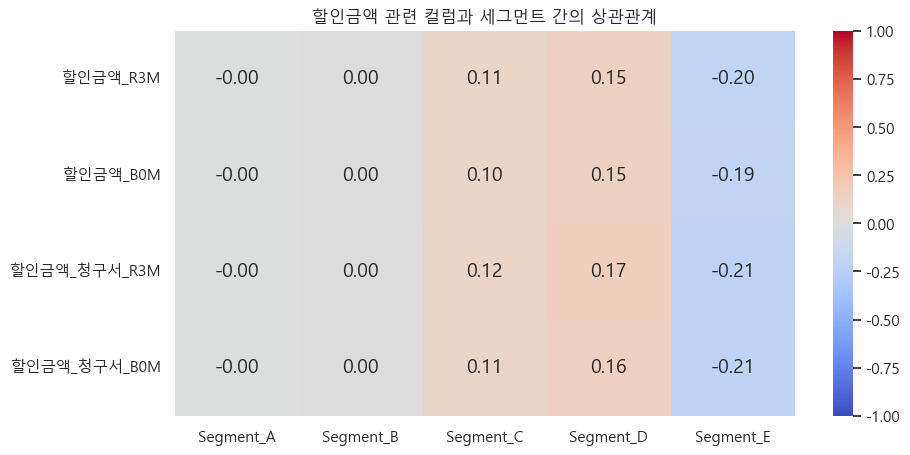

In [39]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False


# 분석에 사용할 컬럼 목록
target_columns = [
    '할인금액_R3M', 
    '할인금액_B0M', 
    '할인금액_청구서_R3M', 
    '할인금액_청구서_B0M'
]

# 세그먼트 더미 인코딩
df_corr = bill_df_with_segment.copy()
segment_dummies = pd.get_dummies(df_corr['Segment'], prefix='Segment')
df_corr = pd.concat([df_corr[target_columns], segment_dummies], axis=1)

# 상관계수 계산
corr_matrix = df_corr.corr()

# 할인금액 관련 컬럼과 세그먼트 더미만 추출
selected_corr = corr_matrix.loc[target_columns, segment_dummies.columns]

# 히트맵 시각화
plt.figure(figsize=(10, 5))
sns.heatmap(selected_corr, annot=True, fmt=".2f", cmap="coolwarm", vmax=1, vmin=-1)
plt.title("할인금액 관련 컬럼과 세그먼트 간의 상관관계")
plt.show()